
# Parameter estimation from differential equation based models



-   Finally,  we consider fitting the mole balance directly

-   Here we numerically integrate the mole balance with parameters that we want to estimate
-   We use nlinfit to vary the parameters and "fit" the data

-   We need the ODE function which is integrated

-   We need another model function which integrates the ODE with a set of parameters and returns the estimated data points at the same time values

-   Then we let nlinfit do its work.

[pycse.nlinfit](https://www.google.com/#safe=off&q=pycse.nlinfit)



In [1]:
import numpy as np
np.set_printoptions(precision=3)

import matplotlib.pyplot as plt
from scipy.integrate import odeint
from pycse import  nlinfit

t = np.array([0, 50, 100, 150, 200, 250, 300])
Ca = np.array([0.05, 0.038, 0.0306, 0.0256, 0.0222, 0.0195, 0.0174])

Ca0 = 0.05

def dCadt(Ca, t, k, alpha):
    return -k * Ca**alpha

def model(t, k, alpha):
    Ca = odeint(dCadt, Ca0, t, args=(k, alpha))
    return Ca[:,0]  # must return a 1D array here

guess = [0.1, 2.0] # from the linear regression

p, pint, se = nlinfit(model, t, Ca, guess, 0.05)

k_range, alpha_range = np.array(pint)

print('alpha = {} at the 95% confidence level'.format(alpha_range))
print('k = {0} at the 95% confidence level'.format(k_range))

alpha = [ 2.002  2.071] at the 95% confidence level
k = [ 0.126  0.159] at the 95% confidence level


-   The confidence intervals here are identical to the nonlinear fit to the analytical solution!

-   We have essentially solved the same fitting problem

-   Notice again that initial guesses were required




# Effects of uncertainty on reactor design



-   The effects of uncertainty in parameters on design are a result of propagation of errors.

-   If there is uncertainty in a number, and that number is used to calculate another number, then the result will have uncertainty also

-   We can quantitatively determine the uncertainty and how it is propagated

-   see [propagation of uncertainty](http://en.wikipedia.org/wiki/Propagation_of_uncertainty).

If a function depends on parameters (a, b, c &#x2026;) that have corresponding uncertainties (&sigma;\_a, &sigma;\_b, &sigma;\_c,&#x2026;) then the uncertainty in $f$ is approximately:

\begin{align}
s_f = \sqrt{\left( \frac{\partial f}{\partial a}\right)^2 s_a^2 + \left( \frac{\partial f}{\partial b}\right)^2 s_b^2  + \left( \frac{\partial f}{\partial c}\right)^2 s_c^2 + \cdots}
\end{align}

-   Consider we have a parameter k=0.1 1/s with standard error of &sigma;\_k = 0.02, i.e. $k = 0.1 \pm 0.02$ 1/s.

-   If the rate law is $r = k C_A$, and there is no uncertainty in $C_A$, what is the uncertainty in the rate for $C_A=2$?

\begin{align}
\sigma_r = \sqrt{\left(\frac{\partial r}{\partial k}\right)^2\sigma_k^2}
\end{align}

-   Evaluating this leads to &sigma;\_r = C\_A &sigma;\_k = 0.04
-   In other words, the rate will be 0.2 &plusmn; 0.04 mol/L/s

-   It can be tedious to evaluate all of the partial derivatives
-   The `uncertainties` package can help tremendously for this

[uncertainties](https://www.google.com/#safe=off&q=uncertainties)



In [2]:
import uncertainties as u

k = u.ufloat(0.1, 0.02)
CA = 2.0

print('The rate is {0} mol/L/s'.format(k*CA))

The rate is 0.20+/-0.04 mol/L/s


-   `uncertainties` automatically propagates most errors through all standard math operations, and many (but not all) functions.

-   An alternative approach to error propagation is Monte Carlo simulation.

-   In this approach we sample the variables with uncertainty and perform the calculations many times.

-   Then we use statistical analysis to determine the uncertainty of the result.

-   We illustrate the approach on estimating the uncertainty



The average rate is 0.2000004512031849 mol/L/s
The standard error is 0.03999932155957138 mol/L/s
100000000


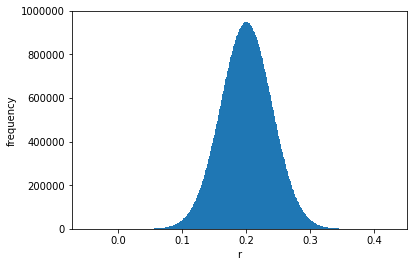

In [4]:
import numpy as np
import matplotlib.pyplot as plt

N = 100000000
muk = 0.1
sigmak = 0.02
k = np.random.normal(muk, sigmak, N)

SE = sigmak / np.sqrt(N)

CA = 2.0

r = k * CA
print('The average rate is {0} mol/L/s'.format(np.mean(r)))
print('The standard error is {0} mol/L/s'.format(np.std(r)))
print(N)

plt.hist(r, 500)
plt.xlabel('r')
plt.ylabel('frequency')
plt.savefig('images/mc-error.png')

![img](./images/mc-error.png)

-   You can see that the distribution appears approximately normally distributed

-   The average is approximately the same as we observed in the previous two approaches

-   The standard error is also approximately the same

-   This approach makes no assumptions about the error propagation other than errors in the parameters are not correlated
    -   we do assume the uncertainty in the parameters is normally distributed
    -   Other distributions could also be used

-   Note it is possible with the normal distribution for $k$ to be negative
    -   This is not physically meaningful
    -   The probability of that happening is very low
    -   $k$ is only approximately normally distributed about the mean, not in the tails




## An application in reactor design



Let us illustrate the effects of uncertainty on the exit concentration of a CSTR.

-   $r_A = k C_A^2$ with $k$ = 3.0 &plusmn; 0.2 L/mol/hr
-   $A$ is fed to the reactor at a rate of 5 &plusmn; 0.05 mol/hr
-   The volumetric flow is 10 &plusmn; 0.1 L/hr
-   The reactor volume is 66000 L

What is the exit concentration?

-   We have to solve $0 = F_{A,in} - F_{A,out} + r_A V$

-   We have several variables to create distributions for. We will create all the samples, and then loop through them and store the result in a vector.



In [5]:
import numpy as np
from scipy.optimize import fsolve

N = 10000    # number of MC samples
V =  66000   # L

Fa0 = np.random.normal(5, 0.05, (1, N))
v0 = np.random.normal(10.0, 0.1, (1, N))
k = np.random.normal(3.0, 0.2, (1, N))

# create the array to store the results in
# It is usually more efficient to create arrays then fill them in.
SOL = np.empty(k.shape)

for i in range(N):
    def func(Ca):
        ra = -k[0,i] * Ca**2
        return Fa0[0,i] - v0[0,i] * Ca + V * ra
    guess = 0.1 * Fa0[0,i] / v0[0,i]  # guessing 90% conversion
    SOL[0,i] = fsolve(func, guess)[0]

print('Ca(exit) = {0}+/-{1}'.format(np.mean(SOL), np.std(SOL)))

# This is an approximate % uncertainty
print(np.std(SOL) / np.mean(SOL) * 100 / 2)

Ca(exit) = 0.0050068117152878575+/-0.00016854659551114484
1.6831728962


-   This analysis shows there is about 2% uncertainty in the exit concentration
    -   that may be acceptable

-   It is not fast to do Monte Carlo
    -   you need many calculations to get good statistics
    -   In some cases you may find not all calculations converge

-   We can also use the `uncertainties` package
    -   We have to do some work to make it work
    -   We have to "wrap" the fsolve function to make it work with uncertainties
    -   but after that, evaluation is fast



In [6]:
import uncertainties as u
from scipy.optimize import fsolve

V = 66000  # reactor volume L^3
Fa0 = u.ufloat(5.0, 0.05)     # mol / h
v0 = u.ufloat(10., 0.1)       # L / h
k = u.ufloat(3.0, 0.2)      # rate constant L/mol/h

# Step 1
def func(Ca, v0, k, Fa0, V):
    "Mole balance for a CSTR. Solve this equation for func(Ca)=0"
    Fa = v0 * Ca     # exit molar flow of A
    ra = -k * Ca**2  # rate of reaction of A L/mol/h
    return Fa0 - Fa + V * ra

# Step 2
def Ca_solve(v0, k, Fa0, V):
    'wrap fsolve to pass parameters as float or units'
    # this line is a little fragile. You must put [0] at the end or
    # you get the NotImplemented result
    guess = 0.1 * Fa0 / v0
    sol = fsolve(func, guess, args=(v0, k, Fa0, V))[0]
    return sol

# Step 3
Ca_exit = u.wrap(Ca_solve)(v0, k, Fa0, V)
print('The exit concentration is {0}'.format(Ca_exit))

The exit concentration is 0.00500+/-0.00017


-   You can see this result is very similar to our Monte Carlo analysis
-   Some disadvantages for this approach are
    -   The need to wrap functions
    -   You cannot perform statistical analysis on the results
        -   This may be important in very nonlinear equations where standard error propagation formulas are not good approximations
-   This simulation assumes the uncertainties in parameters are uncorrelated, i.e. they are independent




# Differential flow reactors for determining rate laws



-   For many reactions it is not feasible to perform batch reactions
-   Especially for gas phase reactions on catalysts, a flow reactor is preferrable
-   If we can use a packed bed reactor with an approximately differential (i.e. a small thickness), then it is possible to directly measure the rate of reaction

\begin{align}
\frac{dF_A}{dW} = r_A
\end{align}

-   We approximate the rate as:

\begin{align}
r_A \approx \frac{F_{A,exit} - F_{A0}}{W_b}
\end{align}

where $W_b$ is the weight of the bed, $F_{A,exit} = \nu C_A$ is the molar flow of $A$ out of the reactor, and $F_{A0}$ is the molar flow entering the reactor

-   It is important that $W_b$ is small, to keep the total conversion as small as possible while still being able to measure changes in the molar flows
    -   Low total conversion is important so you can assume $C_A$ is essentially constant in the reactor bed

-   Instead of measuring a small change in the reactants, you may also measure the increase in molar flow rate of products, which increase from zero (assuming they are not in the feed)

-   In this reactor setup, you measure $r_A$ as a function of inlet conditions, and then fit the data to a proposed rate law

-   Here is an example of rate data from a differential reactor as a function of inlet concentration of $A$
    -   We assume that $r_1 = k C_A^\alpha$ and fit the model to the data



In [7]:
import numpy as np
from pycse import nlinfit

C_A = np.array([1.0, 4.0, 2.0, 0.1, 0.5])    # mol/m^3
r_1 = np.array([1.2, 2.0, 1.36, 0.36, 0.74]) # mol/m^3/min

def rate(Ca, k, alpha):
    return k * Ca**alpha

p, pint, se = nlinfit(rate, C_A, r_1, [10, 0.5])
print('k is between {0}'.format(pint[0]))
print('alpha is between {0}'.format(pint[1]))

k is between [ 0.9    1.234]
alpha is between [ 0.304  0.588]
